# Introduction

Here we are finalising the information that we would like to gather from the molecules db. Specifically, we would want tabled information for each ingredient, containing the proportions of molecules for each ingredient.

# Overview

Getting this finalised dataset entails:

- Selecting from duplicate content entries (selecting orig_foods)
- Averaging from duplicate content entries
- Aggregating final dataset

# Setup

In [1]:
#|default_exp molecule.finalise

In [2]:
#| export
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

In [3]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from food_database.molecule.match import *
from food_database.density.food_match import *

from functools import reduce

import pickle

In [4]:
#| export
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
ingredients_df = pd.read_feather('../data/local/recipe/partial/ingredients/0.feather')
expanded_ingredients_df = pd.read_feather('../data/local/recipe/partial/expanded_ingredients/0.feather')
food_df = pd.read_feather('../data/local/molecule/full/food/1_processed.feather')
content_df = pd.read_feather('../data/local/molecule/full/content/1_processed.feather')
compound_df = pd.read_feather('../data/local/molecule/full/compound/1_processed.feather')
food_ids = pd.read_feather('../data/local/molecule/partial/food_ids/1_na_filled.feather')

# Averaging Duplicate Content Values

Here we have entries of each compound measurement - measured in a standardised concentration of mg/100g. What we want to form is a table of the foods, with features for the concentration of each chemical compound. 

### Handling NA's

#### Content DF

The NA measuremnets coming from this dataset we have already established as seen compounds, but without having thier concentrations measured. How do we deal with this numerically?

Since they are registered as being seen, we should have a (>0) value for them. What makes the most sense is to use the total mean of this value.

#### Expanded DF

Since the data here comes from various sources, there is not a standardised set of measured compounds, so not all foods will have the full featureset. These NA's can be filled as 0, as there was no study which registered them as being present.

In [6]:
content_df['concentration'].notnull().sum() / content_df.index.get_level_values(1).nunique()

9.853602148709754

In [7]:
mean_source_concentrations = content_df.groupby('source_id').apply(lambda item: item['concentration'].mean(skipna=True))
mean_source_concentrations

source_id
4            0.38438
13          1.223154
14        535.347763
24          0.113715
25          0.902589
             ...    
139984          <NA>
139985          <NA>
139986          <NA>
139987          <NA>
139988          <NA>
Length: 58826, dtype: object

Filtering compounds without any measured values.

In [8]:
content_df = content_df.loc[~content_df.index.get_level_values(1).isin(mean_source_concentrations.index[mean_source_concentrations.isna()])]

In [9]:
mean_source_concentrations = content_df.groupby('source_id').apply(lambda item: item['concentration'].mean(skipna=True))
assert mean_source_concentrations.isna().sum() == 0

In [10]:
content_df = content_df.reset_index(0)
content_df['concentration'] = content_df['concentration'].fillna(mean_source_concentrations)
content_df = content_df.reset_index().set_index(['food_id', 'source_id'])

## Formatting

In [11]:
food_compounds_df = pd.pivot_table(content_df, index='food_id', columns='source_id', values='concentration', aggfunc='mean', fill_value=pd.NA)
food_compounds_df

source_id,4,13,14,24,25,27,31,35,40,41,...,125217,125218,125219,125220,125221,125222,125223,125225,125226,125227
food_id,,,,,,,,,,,,,,,,,,,,,
0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1157,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1158,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Filtering Nulls

### Rows

In [12]:
notna = food_compounds_df.notna().sum(axis=1)
notna

food_id
0       333
1       449
2       428
3        75
4       337
       ... 
1156     98
1157    183
1158    141
1159      1
1160      2
Length: 1161, dtype: int64

Removing foods with low compound measurements.

In [13]:
notna = food_compounds_df.notna().sum(axis=1)
notna

food_id
0       333
1       449
2       428
3        75
4       337
       ... 
1156     98
1157    183
1158    141
1159      1
1160      2
Length: 1161, dtype: int64

In [14]:
notna.mean(), notna.std()

(172.49698535745048, 151.38414324859454)

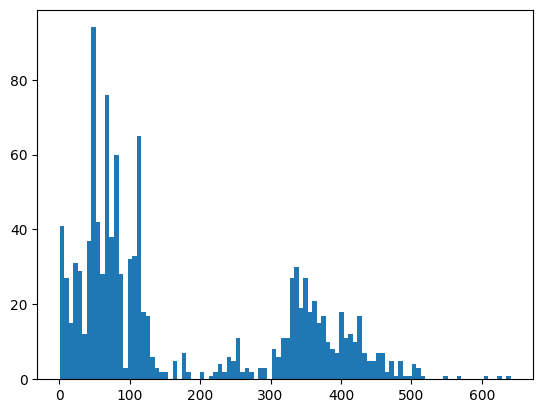

In [15]:
plt.hist(notna, bins=100);

There are still many foods with near 0 compound information. Which foods are they?

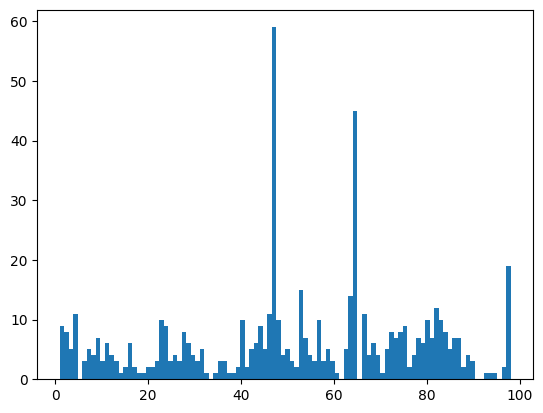

In [16]:
plt.hist(notna[notna<100], bins=100);

In [17]:
notna[notna < 10].to_frame('contents_count').join(food_df['name'])['name']

food_id
13                        dill
33                    kohlrabi
124             common oregano
199                  gram bean
219                    ginseng
228                        NaN
239                        NaN
252                   pak choy
385           alaska blueberry
386              hyacinth bean
393                     jujube
400             leather chiton
404           american lobster
434           pacific rockfish
467             common salsify
468                  sapodilla
477                ringed seal
478                  sea trout
484                 sheepshead
491                      squab
512                        NaN
522             yellowfin tuna
541              domestic goat
546                     shrimp
549               domestic pig
550                     walrus
598             clawed lobster
624     columbidae dove pigeon
680                     casein
713                      kefir
801          oil-seed camellia
886                       pome


It's good to see these are simply just obscure ingredients, which can quite easily be removed.

In [18]:
food_compounds_df = food_compounds_df[(notna > 10) | food_compounds_df.index.isin([1025, 1026])]
food_compounds_df.shape

(1106, 1746)

### Columns

Removing compounds with low total appearances.

In [19]:
notna_cols = food_compounds_df.notna().sum(axis=0)
notna_cols

source_id
4         2
13        1
14        4
24        2
25        2
         ..
125222    2
125223    2
125225    2
125226    2
125227    3
Length: 1746, dtype: int64

In [20]:
notna_cols.index[notna_cols<10].shape

(1003,)

In [21]:
food_compounds_df = food_compounds_df.loc[:, (notna_cols>10)]
food_compounds_df.shape

(1106, 713)

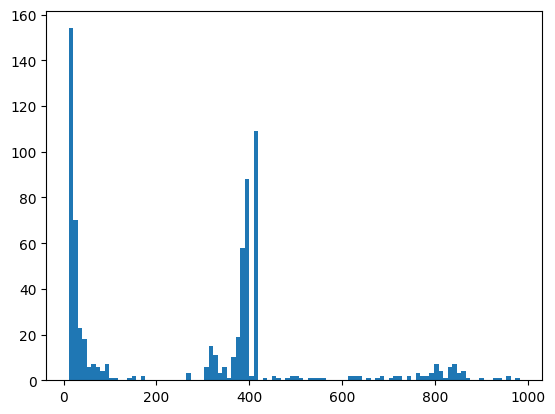

In [22]:
plt.hist((food_compounds_df.notna()).sum(axis=0), bins=100);

In [23]:
food_compounds_df = food_compounds_df.fillna(0)

In [24]:
assert (food_compounds_df > 1e3/1e-2).sum().sum() == 0 

## Converting

These above are using the weight concentration ratio measured in mg/100g.

# Testing

In [28]:
ingredients_df.join(food_ids)[['food_id']].join(food_compounds_df, on=['food_id'])

food_id  108  136       236  237  247  248  249  307  312  \
recipe  ingredient                                                              
1746116 0             667.0  0.0  0.0  0.109333  0.0  0.0  0.0  0.0  0.0  0.0   
        1             670.0  0.0  0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        2             633.0  0.0  0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        3             195.0  0.0  0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        4             825.0  0.0  0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                     ...  ...  ...       ...  ...  ...  ...  ...  ...  ...   
931097  9             994.0  0.0  0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        10             40.0  0.0  0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        11            125.0  0.0  0.0  0.109333  0.0  0.0  0.0  0.0  0.0  0.0   
        12            334.0  0.0  0.0  0.109333  0.0  0.0  0.0  0.0  0.0  0.0   
        13            119.0  0.0  0.0  0.109333  0.0  0.0  0.0  0.0  0.0  0.0   

                    ...    122183    122207    122257    122370    122486  \
recipe  ingredient  ...                                                     
1746116 0           ...  23.49215  9.498727  2.253628  9.376545  9.376545   
        1           ...       0.0       0.0       0.0       0.0       0.0   
        2           ...       0.0       0.0       0.0       0.0       0.0   
        3           ...       0.0       0.0       0.0       0.0       0.0   
        4           ...       0.0       0.0       0.0       0.0       0.0   
...                 ...       ...       ...       ...       ...       ...   
931097  9           ...       0.0       0.0       0.0       0.0       0.0   
        10          ...       0.0       0.0       0.0       0.0       0.0   
        11          ...  23.49215  9.498727  2.253628  9.376545  9.376545   
        12          ...  23.49215  9.498727  2.253628  9.376545  9.376545   
        13          ...  23.49215  9.498727  2.253628  9.376545  9.376545   

                       122510    123210  125087  125196  125197  
recipe  ingredient                                               
1746116 0           24.419212  0.023016     0.0     0.0     0.0  
        1                 0.0       0.0     0.0     0.0     0.0  
        2                 0.0       0.0     0.0     0.0     0.0  
        3                 0.0       0.0     0.0     0.0     0.0  
        4                 0.0       0.0     0.0     0.0     0.0  
...                       ...       ...     ...     ...     ...  
931097  9                 0.0       0.0     0.0     0.0     0.0  
        10                0.0       0.0     0.0     0.0     0.0  
        11          24.419212  0.023016     0.0     0.0     0.0  
        12          24.419212  0.023016     0.0     0.0     0.0  
        13          24.419212  0.023016     0.0     0.0     0.0  

[2450 rows x 714 columns]

# Saving

In [29]:
food_compounds_df

source_id,108,136,236,237,247,248,249,307,312,313,...,122183,122207,122257,122370,122486,122510,123210,125087,125196,125197
food_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0
1,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,1.223189
2,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0
1155,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0
1156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
food_compounds_df.to_feather('../data/local/molecule/full/food_compounds/0.feather')
food_compounds_df.shape

(1106, 713)